# Initialization

In [1]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2,sys
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes, normalize
import importlib
#importlib.reload(utils.decode_netout)
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

Using TensorFlow backend.
/home/staff1/ctorney/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
LABELS = ['wildebeest']

IMAGE_H, IMAGE_W = 154*32, 230*32
# predictions reduce resolution by x32
GRID_H,  GRID_W  = IMAGE_H//32, IMAGE_W//32
# each cell is going to be 32x32
BOX              = 1
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5 # this must be for showing the object - should be lower??
NMS_THRESHOLD    = 0.1#0.45 # non max suppression - what does this do?

# this is the width/height of the anchor boxes - this will be 2,2 for all 5 - maybe - might be better to use pretrained
#ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
ANCHORS          = [2.0,2.0]

# scales - for training maybe?? no idea
# all seem to be in the custom loss function - some method to weight the loss
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


sys.path.append("..")
from yolo_models import get_yolo2

model = get_yolo2(IMAGE_W,IMAGE_H)
model.load_weights('../weights/wb_ce_yolo.h5') 
#model.load_weights('../weights/wb_yolo.h5') 
#model.load_weights('../weights/darknet19-cls.h5', by_name=True)

# Construct the network

In [3]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
#def space_to_depth_x2(x):
#    return tf.space_to_depth(x, block_size=2)

In [4]:
model.summary()
# each grid cell is going to predict 80 - classes + 5 bounding box parameters, 2*size/pos and one for objectedness??

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4928, 7360, 3 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 4928, 7360, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 4928, 7360, 3 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 4928, 7360, 3 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

In [5]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

**Setup a few callbacks and start the training**

# Perform detection on image

In [6]:

#model.load_weights("../weights/wb-yolo.h5")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [7]:

ROOTDIR = '../../'
image_dir = ROOTDIR + '/data/2015/'
img = cv2.imread(image_dir + 'SWC1077.JPG')#1077.JPG') #1149.JPG')


img = img[0:IMAGE_H, 0:IMAGE_W,:]
#im = img.astype('float32')/255
#ny = im.shape[0]
#nx = im.shape[1]

#print(im.shape)
#num_classes = 2 
#image = cv2.imread('raccoon-190.jpg')



input_image = cv2.resize(img, (IMAGE_W, IMAGE_H))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)




In [8]:
def interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3


def decode_netout2(netout, obj_threshold, nms_threshold, anchors, nb_class):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = sigmoid(netout[..., 4]) 
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
        
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                
                #if b!=1:
                #    continue
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
    
                if classes.any():
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                        
                    box = BoundBox(x, y, w, h, confidence, classes)
                        
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
                
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                        
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0 
                            
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    return boxes
def sigmoid(x):
    return 1. / (1. + np.exp(-x))
def softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)

    if np.min(x) < t:
        x = x/np.min(x)*t

    e_x = np.exp(x)

    return e_x / e_x.sum(axis, keepdims=True)

class BoundBox:
    def __init__(self, x, y, w, h, c = None, classes = None):
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h

        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score
def bbox_iou(box1, box2):
    x1_min  = box1.x - box1.w/2
    x1_max  = box1.x + box1.w/2
    y1_min  = box1.y - box1.h/2
    y1_max  = box1.y + box1.h/2

    x2_min  = box2.x - box2.w/2
    x2_max  = box2.x + box2.w/2
    y2_min  = box2.y - box2.h/2
    y2_max  = box2.y + box2.h/2

    intersect_w = interval_overlap([x1_min, x1_max], [x2_min, x2_max])
    intersect_h = interval_overlap([y1_min, y1_max], [y2_min, y2_max])

    intersect = intersect_w * intersect_h

    union = box1.w * box1.h + box2.w * box2.h - intersect

    return float(intersect) / union

def draw_boxes2(image, boxes, labels):
        
    for box in boxes:
        xmin  = int((box.x - box.w/2) * image.shape[1])
        xmax  = int((box.x + box.w/2) * image.shape[1])
        ymin  = int((box.y - box.h/2) * image.shape[0])
        ymax  = int((box.y + box.h/2) * image.shape[0])

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,255), 3)
#        cv2.putText(image,labels[box.get_label()]+' '+str(box.get_score()),(xmin,ymin-13),cv2.FONT_HERSHEY_SIMPLEX,1e-3*image.shape[0],(0,255,0),2)
    
    return image    


In [9]:
netout = model.predict(input_image)


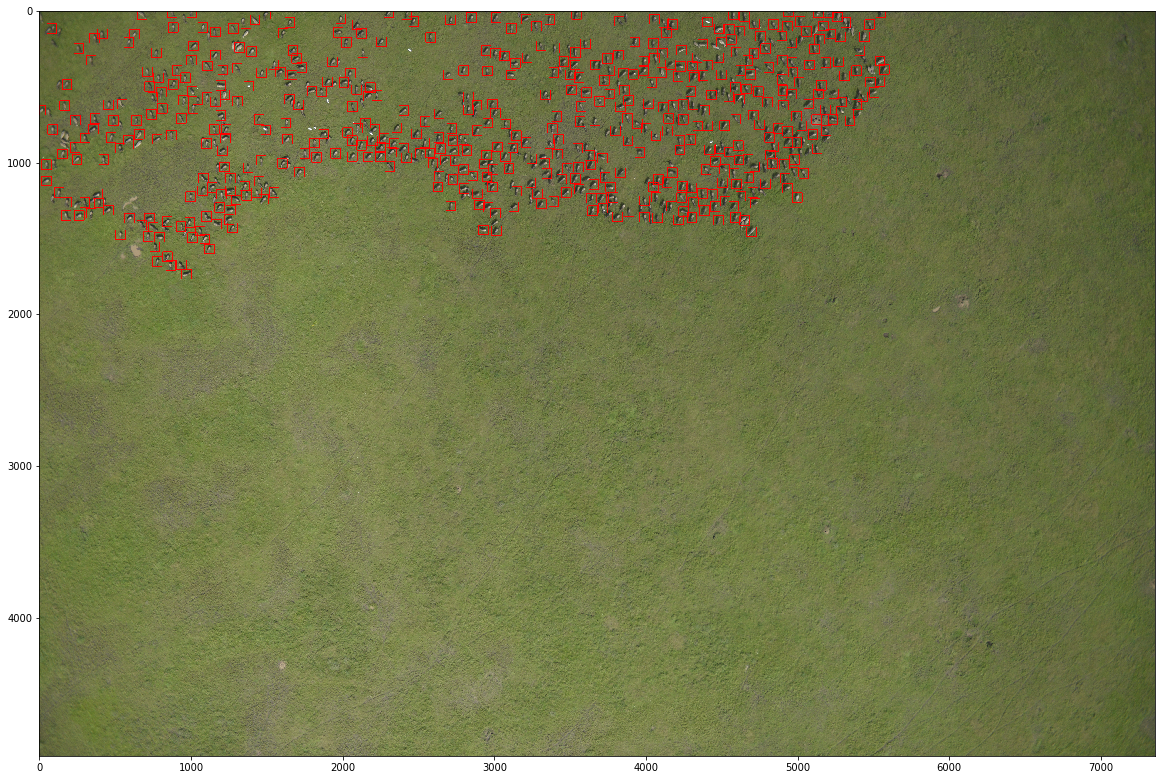

In [12]:
netout = model.predict(input_image)
boxes = decode_netout2(netout[0], 
                      obj_threshold=0.5,#OBJ_THRESHOLD,
                      nms_threshold=0.05,#NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
#img = cv2.imread(image_dir + 'SWC1077.JPG')
#image = img[0:IMAGE_H, 0:IMAGE_W,:]
image = draw_boxes2(img, boxes, labels=LABELS)
plt.figure(figsize=(20,20))
plt.imshow(image[:,:,::-1])
plt.show()

In [11]:
netout[0].shape


(154, 230, 1, 6)